# ch09 数据聚合与分组运算
本章主要学习：
+ 根据一个或多个键（可以是函数、数组或DataFrame列名）拆分pandas对象；
+ 计算分组摘要统计，如计数、平均值、标准差、或用户自定义函数；
+ 对DataFrame的列应用各种各样的函数；
+ 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等；
+ 计算透视表或交叉表；
+ 执行分位数分析以及其他分组分析；

## 9.1 GroupBy技术
分组键可以有多种形式，且类型不必相同：
+ 列表或数组，其长度与待分组的轴一样；
+ 表示DataFrame某个列名的值；
+ 字典或Series，给出待分组轴上的值与分组名之间的对应关系；
+ 函数，用于处理轴索引或索引中的各个标签

后三种都只是快捷方式而已，其最终目的就是产生一组用于拆分对象的值。

In [1]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'key1':['a','a','b','b','a'],
                  'key2':['one','two','one','two','one'],
                  'data1':np.random.randn(5),
                  'data2':np.random.randn(5)})
df

,data1,data2,key1,key2
0,0.774292,-1.099725,a,one
1,1.546395,-0.825704,a,two
2,-0.339573,-1.219544,b,one
3,-0.609450,-0.934268,b,two
4,2.122417,-0.496225,a,one


In [2]:
# 按key1进行分组，并计算data1列的平均值
# 访问data1，并根据key1调用groupby
grouped = df['data1'].groupby(df['key1'])
grouped.mean()

key1
a    1.481035
b   -0.474511
Name: data1, dtype: float64

In [3]:
# 一次传入多个数组
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means

key1  key2
a     one     1.448354
      two     1.546395
b     one    -0.339573
      two    -0.609450
Name: data1, dtype: float64

In [4]:
means.unstack()

key2,one,two
key1,,
a,1.448354,1.546395
b,-0.339573,-0.609450


In [5]:
# 分组键可以是任何长度适当的数组
states = np.array(['Ohio','California','California','Ohio','Ohio'])
years = np.array([2005,2005,2006,2005,2006])
df['data1'].groupby([states,years]).mean()

California  2005    1.546395
            2006   -0.339573
Ohio        2005    0.082421
            2006    2.122417
Name: data1, dtype: float64

In [6]:
# 将列名（可以是字符串、数字或其他Python对象）用作分组键：
df.groupby('key1').mean()

,data1,data2
key1,,
a,1.481035,-0.807218
b,-0.474511,-1.076906


In [7]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one   1.448354 -0.797975
     two   1.546395 -0.825704
b    one  -0.339573 -1.219544
     two  -0.609450 -0.934268

In [8]:
# GroupBy的size方法，可以返回一个含有分组大小的Series
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 9.1.1 对分组进行迭代

In [9]:
for name,group in df.groupby('key1'):
    print name
    print group

a
      data1     data2 key1 key2
0  0.774292 -1.099725    a  one
1  1.546395 -0.825704    a  two
4  2.122417 -0.496225    a  one
b
      data1     data2 key1 key2
2 -0.339573 -1.219544    b  one
3 -0.609450 -0.934268    b  two


In [10]:
for (k1,k2),group in df.groupby(['key1','key2']):
    print k1,k2
    print group

a one
      data1     data2 key1 key2
0  0.774292 -1.099725    a  one
4  2.122417 -0.496225    a  one
a two
      data1     data2 key1 key2
1  1.546395 -0.825704    a  two
b one
      data1     data2 key1 key2
2 -0.339573 -1.219544    b  one
b two
     data1     data2 key1 key2
3 -0.60945 -0.934268    b  two


将这些数据片段做成一个字典：

In [11]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,data1,data2,key1,key2
2,-0.339573,-1.219544,b,one
3,-0.609450,-0.934268,b,two


groupby默认是在axis=0上进行分组，通过设置也可以在其他任何轴上进行分组，例如可以根据dtype对列进行分组：

In [12]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [13]:
grouped = df.groupby(df.dtypes,axis=1)
dict(list(grouped))

{dtype('float64'):       data1     data2
 0  0.774292 -1.099725
 1  1.546395 -0.825704
 2 -0.339573 -1.219544
 3 -0.609450 -0.934268
 4  2.122417 -0.496225, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### 9.1.2 选取一个或一组列
对于由DataFrame产生的GroupBy对象，如果用一个（单个字符串）或一组（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的：

In [14]:
df.groupby(['key1','key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.797975
     two  -0.825704
b    one  -1.219544
     two  -0.934268

这种索引操作所返回的对象是一个已经分组的DataFrame（如果传入的是列表或数组）或已分组的Series（如果传入的是标量形式的单个列名）：

In [15]:
s_grouped = df.groupby(['key1','key2'])['data2']
s_grouped

In [16]:
s_grouped.mean()

key1  key2
a     one    -0.797975
      two    -0.825704
b     one    -1.219544
      two    -0.934268
Name: data2, dtype: float64

### 9.1.3 通过字典或Series进行分组
除数组外，分组信息还可以以其他形式存在：

In [17]:
people = pd.DataFrame(np.random.randn(5,5),
                     columns = ['a','b','c','d','e'],
                     index = ['Joe','Steve','Wes','Jim','Travis'])
people.loc[2:3,['b','c']]=np.nan
people

,a,b,c,d,e
Joe,-0.776402,0.465630,0.272258,-0.901821,0.613637
Steve,-0.496043,0.200563,1.059740,-0.823165,-0.383835
Wes,0.919601,NaN,NaN,-0.989086,-0.686163
Jim,-0.017086,0.693448,-1.908408,-1.104989,1.452396
Travis,0.872347,1.207055,0.767777,0.790866,-1.198196


假设已知列的分组关系，并希望根据分组计算列的总计：

In [18]:
mapping = {'a':'red','b':'red','c':'blue','d':'blue','e':'red','f':'orange'}
by_column = people.groupby(mapping,axis=1)
by_column.sum()

,blue,red
Joe,-0.629562,0.302865
Steve,0.236575,-0.679315
Wes,-0.989086,0.233438
Jim,-3.013397,2.128758
Travis,1.558643,0.881206


Series也有同样的功能，它可以被看作一个固定大小的映射，上例如果用Series作为分组键，则pandas会检查Series以确保其索引跟分组轴是对齐的：

In [19]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [20]:
people.groupby(map_series,axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 9.1.4 通过函数进行分组
任何被当作分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。上例中，若根据人名的长度进行分组，仅传入len函数就可以了：

In [21]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.126113,1.159078,-1.636150,-2.995897,1.379871
5,-0.496043,0.200563,1.059740,-0.823165,-0.383835
6,0.872347,1.207055,0.767777,0.790866,-1.198196


将函数跟数组、列表、字典、Series混合使用也不是问题，因为任何东子最终都会被转换为数组：

In [22]:
key_list=['one','one','one','two','one']
people.groupby([len,key_list]).min()

a         b         c         d         e
3 one -0.776402  0.465630  0.272258 -0.989086 -0.686163
  two -0.017086  0.693448 -1.908408 -1.104989  1.452396
5 one -0.496043  0.200563  1.059740 -0.823165 -0.383835
6 one  0.872347  1.207055  0.767777  0.790866 -1.198196

### 9.1.5 根据索引级别分组
层次化索引数据集最方便的地方就在于它能够根据索引级别进行聚合，要实现该目的，通过level关键字传入级别编号或名称即可：

In [23]:
columns = pd.MultiIndex.from_arrays([['US','US','US','JP','JP'],
                                    [1,3,5,1,3]],names=['city','tenor'])
hier_df = pd.DataFrame(np.random.randn(4,5),columns=columns)
hier_df

city         US                            JP          
tenor         1         3         5         1         3
0     -2.266118 -1.480126 -0.279874  1.346356 -1.102457
1     -0.687946  0.934377 -0.375800 -0.452301 -0.851827
2     -0.396683  0.469104  0.334455 -1.088527 -0.202440
3     -1.234072  0.129828  0.412888 -1.068969 -1.096917

In [24]:
hier_df.groupby(level='city',axis=1).count()

city,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 9.2 数据聚合

In [25]:
df

,data1,data2,key1,key2
0,0.774292,-1.099725,a,one
1,1.546395,-0.825704,a,two
2,-0.339573,-1.219544,b,one
3,-0.609450,-0.934268,b,two
4,2.122417,-0.496225,a,one


In [26]:
grouped = df.groupby('key1')
 # quantile可以计算Series或DataFrame列的样本分位数
grouped['data1'].quantile(0.9)

key1
a    2.007212
b   -0.366560
Name: data1, dtype: float64

虽然quantile并没有明确地实现于GroupBy，但它是一个Series方法，所以这里是能用的。实际上，GroupBy会高效地对Series进行切片，然后对各片调用piece.quantile（0.9），最后将这些结果组装成最终结果。

如果要使用自己的聚合函数，只需将其传入aggregate或agg方法即可：

In [27]:
def peak_to_peak(arr):
    return arr.max()-arr.min()

grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.348125,0.603500
b,0.269878,0.285276


有些方法（如describe）也是可以用在这里的，即使严格上来讲，它们并非聚合运算：

In [28]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  1.481035  0.676435  0.774292  1.160343  1.546395  1.834406   
b      2.0 -0.474511  0.190832 -0.609450 -0.541981 -0.474511 -0.407042   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     2.122417   3.0 -0.807218  0.302174 -1.099725 -0.962715 -0.825704   
b    -0.339573   2.0 -1.076906  0.201721 -1.219544 -1.148225 -1.076906   

                          
           75%       max  
key1                      
a    -0.660965 -0.496225  
b    -1.005587 -0.934268

表9-1：经过优化的groupby的方法

| 函数名        | 说明                   |
|:------------- |:-------------|
| count    | 分组中非NA值的数量   |
| sum     | 非NA值的和    |
| mean    | 非NA值的平均值 |
| median   | 非NA值的算数中位数 |
| std/var  | 无偏（分母为n-1）标准差和方差 |
| min/max | 非NA值的最小值和最大值|
| prod | 非NA值的积 |
| first/last | 第一个和最后一个非NA值|

In [29]:
tips = pd.read_csv('D:/python-dataset/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [30]:
# 添加“小费占总额百分比”的列
tips['tip_pct'] = tips['tip']/tips['total_bill']
tips[:6]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


### 9.2.1 面向列的多函数应用
对Series或DataFrame列的聚合运算其实就是使用aggregate（使用自定义函数）或调用诸如mean、std之类的方法。然而，可能有些需求需要对不同的列使用不同的聚合函数，或一次应用多个函数。

In [31]:
# 根据sex和smoker对tips分组：
grouped = tips.groupby(['sex','smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [32]:
# 传入一组函数或函数名
grouped_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [33]:
# 自定义列名
grouped_pct.agg([('foo','mean'),('bar',np.std)])

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

In [34]:
# 向多列应用多个函数
functions = ['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [35]:
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

In [36]:
ftuples = [('Durchschnitt','mean'),('Abweichung',np.var)]
grouped['tip_pct','total_bill'].agg(ftuples)

tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

In [37]:
# 对不同列应用不同函数
grouped.agg({'tip':np.max,'size':'sum'})

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [38]:
grouped.agg({'tip_pct':['min','max','mean','std'],'size':'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

### 9.2.2 以“无索引”的形式返回聚合数据

In [39]:
# 可以向GroupBy传入as_index=False以禁用该功能
tips.groupby(['sex','smoker'],as_index=False).mean()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


In [40]:
# 对结果调用reset_index()也能得到这种形式
tips.groupby(['sex','smoker']).mean().reset_index()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


## 9.3 分组级运算和转换
聚合只不过是分组运算中的一种而已，是数据转换的一个特例，本节介绍transform和apply方法，能够执行更多分组运算；

In [41]:
# 为一个DataFrame添加一个用于存放各索引分组平均值的列，一个办法就是先聚合再合并
df

,data1,data2,key1,key2
0,0.774292,-1.099725,a,one
1,1.546395,-0.825704,a,two
2,-0.339573,-1.219544,b,one
3,-0.609450,-0.934268,b,two
4,2.122417,-0.496225,a,one


In [42]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,1.481035,-0.807218
b,-0.474511,-1.076906


In [43]:
pd.merge(df,k1_means,left_on = 'key1',right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,0.774292,-1.099725,a,one,1.481035,-0.807218
1,1.546395,-0.825704,a,two,1.481035,-0.807218
4,2.122417,-0.496225,a,one,1.481035,-0.807218
2,-0.339573,-1.219544,b,one,-0.474511,-1.076906
3,-0.609450,-0.934268,b,two,-0.474511,-1.076906


上述方法虽然可行但不太灵活，可以将该过程看作利用np.mean函数对两个数列进行转换，再以people数据框为例，在GroupBy方法上使用transform方法：

In [44]:
people

,a,b,c,d,e
Joe,-0.776402,0.465630,0.272258,-0.901821,0.613637
Steve,-0.496043,0.200563,1.059740,-0.823165,-0.383835
Wes,0.919601,NaN,NaN,-0.989086,-0.686163
Jim,-0.017086,0.693448,-1.908408,-1.104989,1.452396
Travis,0.872347,1.207055,0.767777,0.790866,-1.198196


In [45]:
key = ['one','two','one','two','one']
people.groupby(key).mean()

,a,b,c,d,e
one,0.338515,0.836343,0.520018,-0.366680,-0.423574
two,-0.256565,0.447006,-0.424334,-0.964077,0.534281


In [46]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,0.338515,0.836343,0.520018,-0.366680,-0.423574
Steve,-0.256565,0.447006,-0.424334,-0.964077,0.534281
Wes,0.338515,0.836343,0.520018,-0.366680,-0.423574
Jim,-0.256565,0.447006,-0.424334,-0.964077,0.534281
Travis,0.338515,0.836343,0.520018,-0.366680,-0.423574


可见，transform会将一个函数应用到各个分组，然后将结果放置到适当的位置上，如果各分组产生的是一个标量值，则该值就会被广播出去。

现在，假设希望从各组中减去平均值，为此先创建一个距离化函数（demeaning function），然后将其传给transform：

In [47]:
def demean(arr):
    return arr-arr.mean()

demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,-1.114917,-0.370712,-0.247759,-0.535140,1.037211
Steve,-0.239478,-0.246443,1.484074,0.140912,-0.918116
Wes,0.581086,NaN,NaN,-0.622406,-0.262589
Jim,0.239478,0.246443,-1.484074,-0.140912,0.918116
Travis,0.533831,0.370712,0.247759,1.157546,-0.774622


In [48]:
# 检查demeaned现在分组平均值是否为0
demeaned.groupby(key).mean().round()

,a,b,c,d,e
one,0.0,0.0,0.0,0.0,0.0
two,0.0,0.0,0.0,0.0,0.0


### 9.3.1 apply：一般性的“拆分-应用-合并”
跟aggreegate一样，transform也是一个有严格条件的特殊函数：传入的函数只能产生两种结果，要么产生一个可以广播的标量值（如np.mean），要么产生一个相同大小的结果数组。

最一般化的GroupBy方法是apply，下面将重点讲解它，apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

关于tips数据集，假设要根据分组选出最高的5个tip_pct值，首先，编写一个选取指定列具有最大值的行的函数：

In [49]:
def top(df,n=5,column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips,n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [50]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [51]:
tips.groupby(['smoker','day']).apply(top,n=1,column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

在GroupBy对象上，调用诸如describe之类的方法时，实际上只是应用了下面两行代码的快捷方式而已：

In [52]:
grouped = tips.groupby(['smoker'])
f = lambda x:x.describe()
grouped.apply(f)

total_bill         tip        size     tip_pct
smoker                                                      
No     count  151.000000  151.000000  151.000000  151.000000
       mean    19.188278    2.991854    2.668874    0.159328
       std      8.255582    1.377190    1.017984    0.039910
       min      7.250000    1.000000    1.000000    0.056797
       25%     13.325000    2.000000    2.000000    0.136906
       50%     17.590000    2.740000    2.000000    0.155625
       75%     22.755000    3.505000    3.000000    0.185014
       max     48.330000    9.000000    6.000000    0.291990
Yes    count   93.000000   93.000000   93.000000   93.000000
       mean    20.756344    3.008710    2.408602    0.163196
       std      9.832154    1.401468    0.810751    0.085119
       min      3.070000    1.000000    1.000000    0.035638
       25%     13.420000    2.000000    2.000000    0.106771
       50%     17.920000    3.000000    2.000000    0.153846
       75%     26.860000    3.680000    3.000000    0.195059
       max     50.810000   10.000000    5.000000    0.710345

In [53]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [54]:
result.unstack('smoker').unstack()

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


**禁止分组键**

分组键会跟原始对象的索引共同构成结果对象中的层次化索引，可禁止该效果：

In [55]:
tips.groupby('smoker',group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### 9.3.2 分为数和桶分析
pandas有一些能根据指定面元或样本分位数将数据拆分成多块的工具（比如cut和qcut），将这些函数跟groupby结合起来，就能非常轻松地实现对数据集地桶（bucket）或分位数（quantile）分析了。

下例利用cut将简单随机数据集装入长度相等的桶中：

In [56]:
frame = pd.DataFrame({'data1':np.random.randn(1000),
                     'data2':np.random.randn(1000)})
factor = pd.cut(frame.data1,4)
factor[:10]

0    (-1.693, -0.0854]
1     (-0.0854, 1.522]
2    (-1.693, -0.0854]
3     (-0.0854, 1.522]
4    (-1.693, -0.0854]
5    (-1.693, -0.0854]
6     (-0.0854, 1.522]
7    (-1.693, -0.0854]
8    (-1.693, -0.0854]
9     (-0.0854, 1.522]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.306, -1.693] < (-1.693, -0.0854] < (-0.0854, 1.522] < (1.522, 3.129]]

由cut返回的factor对象可直接用于groupby：

In [57]:
def get_stats(group):
    return{'min':group.min(),'max':group.max(),
          'count':group.count(),'mean':group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.306, -1.693]",43.0,1.967062,-0.114952,-2.854295
"(-1.693, -0.0854]",397.0,2.652736,-0.031409,-3.145682
"(-0.0854, 1.522]",506.0,3.492056,-0.022454,-3.327343
"(1.522, 3.129]",54.0,2.460906,0.047506,-2.018905


上述是长度相等的桶（区间大小相等），要根据样本分位数得到大小相等的桶（数据点数量相等），使用qcut即可。传入labels=False即可只获取分位数的编号：

In [58]:
#返回分位数编号
grouping = pd.qcut(frame.data1,10,labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.402699,-0.070122,-2.854295
1,100.0,2.095517,-0.034442,-2.610029
2,100.0,2.652736,0.061584,-2.327360
3,100.0,1.911318,-0.127944,-3.145682
4,100.0,2.089896,-0.064777,-2.468726
5,100.0,1.622299,-0.217434,-3.327343
6,100.0,3.492056,0.113559,-2.922746
7,100.0,2.360988,0.023291,-2.272496
8,100.0,2.211255,0.029607,-2.953855


### 9.3.3 示例：用特定于分组的值填充缺失值
下例用平均值填充NA值：

In [59]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan #每隔两个取值设为nan
s

0         NaN
1    0.097257
2         NaN
3    0.509037
4         NaN
5   -0.175799
dtype: float64

In [60]:
s.fillna(s.mean())

0    0.143498
1    0.097257
2    0.143498
3    0.509037
4    0.143498
5   -0.175799
dtype: float64

假设需要对不同的分组填充不同的值，只需将数据分组，并使用apply和一个能够对各数据块调用fillna的函数就行：

In [61]:
stats = ['Ohio','New York','Vermont','Florida','Oregon','Nevada','California','Idaho']
group_key = ['East']*4 + ['West']*4
data = pd.Series(np.random.randn(8),index=stats)
data[['Vermont','Nevada','Idaho']] = np.nan
data

Ohio         -0.189038
New York     -0.340547
Vermont            NaN
Florida       2.107192
Oregon        1.137646
Nevada             NaN
California    0.471913
Idaho              NaN
dtype: float64

In [62]:
data.groupby(group_key).mean()

East    0.525869
West    0.804779
dtype: float64

In [63]:
# 用分组平均值填充NA值
fill_mean = lambda g:g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.189038
New York     -0.340547
Vermont       0.525869
Florida       2.107192
Oregon        1.137646
Nevada        0.804779
California    0.471913
Idaho         0.804779
dtype: float64

此外也可以在代码中预定义各组的填充值，由于分组具有一个name属性，所以可以用一下：

In [64]:
fill_values = {'East':0.5,'West':-1}
fill_func = lambda g:g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio         -0.189038
New York     -0.340547
Vermont       0.500000
Florida       2.107192
Oregon        1.137646
Nevada       -1.000000
California    0.471913
Idaho        -1.000000
dtype: float64

### 9.3.4 示例：随机采样和排列
假设要从一个大数据集中随机抽样进行蒙特卡洛模拟或其他分析工作，“抽取”的方式很多，其中一些的效率会比其他的高很多。

一个方法是，选取np.random.permutation(N)的前K个元素，其中N为完整数据的大小，K为期望的样本大小。

下例构造一副英语型扑克牌的一个方式：

In [67]:
# 红桃（Hearts）、黑桃（Spades）、梅花（Clubs）、方片（Diamonds）
suits = ['H','S','C','D']
card_val = (range(1,11)+[10]*3)*4
base_names = ['A'] + range(2,11) + ['J','K','Q']
cards = []
for suit in ['H','S','C','D']:
    cards.extend(str(num) + suit for num in base_names)
    
deck = pd.Series(card_val,index=cards)

deck为一个长度为52的Series，其索引为牌名，值则是21点或其他游戏中用于计分的点数：

In [70]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [74]:
# 从整副牌中抽出5张
def draw(deck,n=5):
    return deck.take(np.random.permutation(len(deck))[:n])

draw(deck)

6H      6
3C      3
8S      8
4D      4
10S    10
dtype: int64

In [76]:
# 从每种花色中随机抽出两张牌，由于花色是牌名最后一个字符，所以可以据此分组
get_suit = lambda card:card[-1] # 只要最后一个字母
deck.groupby(get_suit).apply(draw,n=2)

C  10C    10
   QC     10
D  AD      1
   6D      6
H  4H      4
   8H      8
S  8S      8
   7S      7
dtype: int64

In [79]:
# 另一种方法
deck.groupby(get_suit,group_keys=False).apply(draw,n=2)

3C      3
6C      6
7D      7
2D      2
9H      9
10H    10
6S      6
3S      3
dtype: int64

### 9.3.5 示例：分组加权平均数和相关系数
根据GroupBy的“拆分-应用-合并”范式，DataFrame的列与列之间或两个Series之间的运算（比如分组加权平均）成为一种标准作业。以下面数据集为例，它含有分组键、值以及一些权重值：

In [84]:
df = pd.DataFrame({'category':['a','a','a','a','b','b','b','b'],
                  'data':np.random.randn(8),
                  'weights':np.random.rand(8)})
df

,category,data,weights
0,a,-0.140176,0.090398
1,a,-0.791642,0.812363
2,a,0.316439,0.720406
3,a,-2.302739,0.219452
4,b,-0.092952,0.563725
5,b,-1.386632,0.590158
6,b,-1.965963,0.964730
7,b,1.531403,0.767897


In [81]:
# 利用category计算分组加权平均
grouped = df.groupby('category')
get_wavg = lambda g:np.average(g['data'],weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.346058
b    0.846773
dtype: float64

再看一个例子，来自yahoo！finance的数据集，其中含有标准普尔500指数（SPX字段）和几只股票的收盘价：

In [85]:
close_px = pd.read_csv('D:/python-dataset/stock_px.csv',parse_dates=True,index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [86]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


计算一个由日收益率（通过百分比数变化计算）与SPX之间的年度相关系数组成的DataFrame：

In [90]:
rets = close_px.pct_change().dropna()
spx_corr = lambda x:x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x:x.year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [96]:
# 还可以计算列与列之间的相关系数
# 苹果和微软的年度相关系数
by_year.apply(lambda g:g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 9.3.6 示例：面向分组的线性回归
顺着上一个例子继续，可以用groupby执行更为复杂的分组统计分析，只要函数返回的是pandas对象或标量值即可。例如，可以定义下面这个regress函数（利用statsmodels库）对各数据块执行普通最小二乘法（Ordinary Least Squares，OLS）回归：

In [97]:
import statsmodels.api as sm

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [98]:
#from pandas.core import datetools
def regress(data,yvar,xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept']=1.
    result = sm.OLS(Y,X).fit()
    return result.params

In [99]:
# 按年计算AAPL对SPX收益率的线性回归，执行：
by_year.apply(regress,'AAPL',['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 9.4 透视表和交叉表
透视表（pivot table），根据一个或多个键对数据进行聚合，并根据行和列上的分组键将数据分配到各个矩形区域中。

在Python和Pandas中，可以通过groupby功能以及（能够利用层次化索引）重塑运算制作透视表；DataFrame有一个pivot_table方法，还有一个顶级的pandas.pivot_table函数，除能为groupby提供便利之外，pivot_table还可以添加分项小计（也叫margins）。

回到tips数据集，假设想要根据sex和smoker计算分组平均数（pivot_table的默认聚合类型），并将sex和smoker放到行上：

In [104]:
#pivot_table(data, values=None, index=None, columns=None, aggfunc='mean',
#fill_value=None, margins=False, dropna=True, margins_name='All')
tips.pivot_table(index=['sex','smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

假设只想聚合tip_pct和size，而且想根据day进行分组，将smoker放到列上，把day放到行上：

In [106]:
tips.pivot_table(values=['tip_pct'],index=['sex','day'],columns=['smoker'])

tip_pct          
smoker             No       Yes
sex    day                     
Female Fri   0.165296  0.209129
       Sat   0.147993  0.163817
       Sun   0.165710  0.237075
       Thur  0.155971  0.163073
Male   Fri   0.138005  0.144730
       Sat   0.162132  0.139067
       Sun   0.158291  0.173964
       Thur  0.165706  0.164417

还可以对这个表作进一步处理，传入margins=True添加分项小计。这将会添加标签为ALL的行和列，其值对应于单个等级中所有数据的分组统计。

下例中，ALL值为平均数，不单独考虑烟民与非烟民（ALL列），不单独考虑行分组两个级别中的任何单项（ALL行）。

In [110]:
tips.pivot_table(['tip_pct','size'],index=['sex','day'],
                columns='smoker',margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   2.500000  2.000000  2.111111  0.165296  0.209129  0.199388
       Sat   2.307692  2.200000  2.250000  0.147993  0.163817  0.156470
       Sun   3.071429  2.500000  2.944444  0.165710  0.237075  0.181569
       Thur  2.480000  2.428571  2.468750  0.155971  0.163073  0.157525
Male   Fri   2.000000  2.125000  2.100000  0.138005  0.144730  0.143385
       Sat   2.656250  2.629630  2.644068  0.162132  0.139067  0.151577
       Sun   2.883721  2.600000  2.810345  0.158291  0.173964  0.162344
       Thur  2.500000  2.300000  2.433333  0.165706  0.164417  0.165276
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [111]:
# 使用其他的聚合函数
tips.pivot_table(values=['tip_pct'],index=['sex','smoker'],
                columns='day',aggfunc=len,margins=True)

tip_pct                         
day               Fri   Sat   Sun  Thur    All
sex    smoker                                 
Female No         2.0  13.0  14.0  25.0   54.0
       Yes        7.0  15.0   4.0   7.0   33.0
Male   No         2.0  32.0  43.0  20.0   97.0
       Yes        8.0  27.0  15.0  10.0   60.0
All              19.0  87.0  76.0  62.0  244.0

In [115]:
# 如果存在空的组合（NA），可以设置一个fill_value
tips.pivot_table(values='size',index=['time','sex','smoker'],
                columns='day',aggfunc='sum',fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

### 9.4.1 交叉表：crosstab
交叉表（cross-tabulation，简称crasstab）是一种用于计算**分组频率**的特殊透视表：

In [136]:
data = pd.DataFrame({'Sample':range(1,11),
                    'Gender':['Female','Male','Female','Male','Male','Male','Female',
                              'Female','Male','Female'],
                    'Handedness':['Right-handed','Left-handed','Right-handed',
                                  'Right-handed','Left-handed','Right-handed',
                                  'Right-handed','Left-handed','Right-handed',
                                  'Right-handed']},
                   columns=['Sample','Gender','Handedness'])
data

#from StringIO import StringIO
#data = """\
#Sample    Gender    Handedness
#1    Female    Right-handed
#2    Male    Left-handed
#3    Female    Right-handed
#4    Male    Right-handed
#5    Male    Left-handed
#6    Male    Right-handed
#7    Female    Right-handed
#8    Female    Left-handed
#9    Male    Right-handed
#10    Female    Right-handed"""
#data = pd.read_table(StringIO(data), sep='\s+')

,Sample,Gender,Handedness
0,1,Female,Right-handed
1,2,Male,Left-handed
2,3,Female,Right-handed
3,4,Male,Right-handed
4,5,Male,Left-handed
5,6,Male,Right-handed
6,7,Female,Right-handed
7,8,Female,Left-handed
8,9,Male,Right-handed
9,10,Female,Right-handed


In [137]:
pd.crosstab(data.Gender,data.Handedness,margins=True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


crosstab前两个参数可以是数组、Series或数组列表，再比如对tips数据集：

In [138]:
pd.crosstab([tips.time,tips.day],tips.smoker,margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 9.5 2012联邦选举委员会数据库
美国联邦选举委员会发布了有关政治竞选赞助方面的数据，其中包括赞助者的姓名、职业、雇主、地址以及出资额等信息，加载数据进来：

In [139]:
fec = pd.read_csv('D:/python-dataset/P00000001-ALL.csv')
fec.info()

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [140]:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

该数据中没有党派信息，最好加进去，通过unique，可以获取全部的候选人名单（注意，NumPy不会输出信息中字符串两侧的引号）：

In [141]:
unique_cands=fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [142]:
unique_cands[2]

'Obama, Barack'

In [146]:
# 最简单的办法是利用字典说明党派关系
parties = {'Bachmann, Michelle':'Republican',
           'Romney, Mitt':'Republican',
           'Obama, Barack':'Democrat',
           "Roemer, Charles E. 'Buddy' III":'Republican',
           'Pawlenty, Timothy':'Republican',
           'Johnson, Gary Earl':'Republican',
           'Paul, Ron':'Republican',
           'Santorum, Rick':'Republican', 
           'Cain, Herman':'Republican',
           'Gingrich, Newt':'Republican',
           'McCotter, Thaddeus G':'Republican',
           'Huntsman, Jon':'Republican',
           'Perry, Rick':'Republican'}
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [147]:
fec['parties'] = fec.cand_nm.map(parties)
fec['parties'].value_counts()

Democrat      593746
Republican    407985
Name: parties, dtype: int64

In [148]:
# 该数据既包括赞助也包括退款（负的出资额）
(fec.contb_receipt_amt>0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [149]:
# 限定该数据集只有正的出资额
fec = fec[fec.contb_receipt_amt>0]

In [150]:
# Obama, Barack和Romney, Mitt是最主要的两名候选人，准备只包含两人的子集
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack','Romney, Mitt'])]

### 9.5.1 根据职业和雇主统计赞助信息
基于职业的赞助信息统计是另一种经常被研究的统计任务，首先根据职业计算出资总额：

In [151]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [152]:
# 处理类似职业名
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS':'NOT PROVIDED',
    'INFORMATION REQUESTED':'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)':'NOT PROVIDED',
    'C.E.O':'CEO'
}
# 如果没有提供相关映射，则返回x
f = lambda x:occ_mapping.get(x,x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

# 对雇主信息也进行同样的处理
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS':'NOT PROVIDED',
    'INFORMATION REQUESTED':'NOT PROVIDED',
    'SELF':'SELF-EMPLOYED',
    'SELF EMPLOYED':'SELF-EMPLOYED'
}
# 如果没有提供相关映射，则返回x
f = lambda x:emp_mapping.get(x,x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [155]:
# 通过pivot_table根据党派和职业对数据进行聚合，然后过滤掉总出资额不足200万美元的数据
by_occupation = fec.pivot_table('contb_receipt_amt',
                               index='contbr_occupation',
                               columns='parties',aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1)>2000000]
over_2mm

parties,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
C.E.O.,1690.00,2.592983e+06
CEO,2074284.79,1.640758e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05


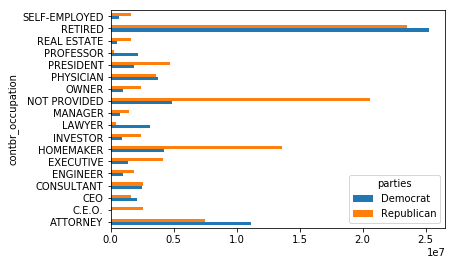

In [159]:
% matplotlib inline
over_2mm.plot(kind='barh')

In [173]:
# 对Obama和Romney总出资额最高的职业和企业
def get_top_amounts(group,key,n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    
    # 根据key对totals进行降序排列
    return totals.sort_values(ascending=False)[:n]

# 然后根据职业和雇主进行聚合
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts,'contbr_occupation',n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

### 9.5.2 对出资额分组
利用cut函数根据出资额的大小将数据离散化到多个面元中：

In [176]:
bins = np.array([0,1,10,100,1000,10000,100000,1000000,10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt,bins)
labels.describe()

count        694282
unique            8
top       (10, 100]
freq         404133
Name: contb_receipt_amt, dtype: object

In [182]:
# 根据候选人姓名以及面元标签对数据进行分组
grouped = fec_mrbo.groupby(['cand_nm',labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [184]:
# 对出资额求和并在面元内规格化，以便图形化显示两位候选人各种赞助额度的比例
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [189]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1),axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


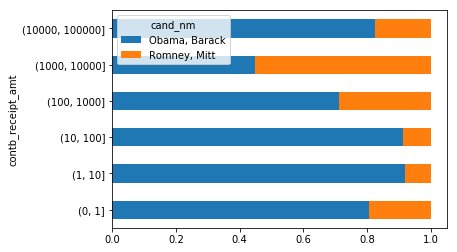

In [198]:
# 排除最大两个不是个人捐赠的面元
normed_sums[:-2].plot(kind='barh',stacked=True)

### 9.5.3 根据州统计赞助信息

In [209]:
# 根据候选人和州对数据进行聚合
grouped = fec_mrbo.groupby(['cand_nm','contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1)>100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [212]:
# 对各行除以总赞助额，就会得到各候选人在各州的总赞助额比例
percent = totals.div(totals.sum(1),axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224


In [219]:
# 在地图上画出百分比
#from basemap import Basemap,cm
import numpy as np
from matplotlib import rcParams
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from shapelib import ShapeFile
import dbflib

ImportError: No module named shapelib

In [218]:
import basemap

ImportError: No module named basemap

In [217]:
obama = percent['Obama,Barack']

fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

lllat = 21
urlat = 53
lllon = -188
urlon = -62

m = Basemap(ax=ax,projection='stere',lon_O=(urlon+lllon)/2,lat_O=(urlat+lllat)/2,
           )

KeyError: 'Obama,Barack'